In [5]:
import os
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [6]:
TRAIN_CSV = "./ml-testing/train.csv"
TRAIN_PATH = "./ml-testing/train"
TEST_PATH = "./ml-testing/test"

WIDTH = 704
HEIGHT = 520

# Reduced the train dataset to 5000 rows
TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 2

# No changes tried with the optimizer yet.
MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Changes the confidence required for a pixel to be kept for a mask. 
# Only used 0.5 till now.
MASK_THRESHOLD = 0.5

# Normalize to resnet mean and std if True.
NORMALIZE = False 


# Use a StepLR scheduler if True. Not tried yet.
USE_SCHEDULER = False

# Number of epochs
NUM_EPOCHS = 8


BOX_DETECTIONS_PER_IMG = 539


MIN_SCORE = 0.59

In [8]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"]
                    }
    
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        
        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
            a_mask = Image.fromarray(a_mask)
            
            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        # dummy labels
        labels = [1 for _ in range(n_objects)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)
def f(x):
    return tuple(zip(*x))
df_train = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)
ds_train = CellDataset(TRAIN_PATH, df_train, resize=False, transforms=get_transform(train=True))
print(np.shape(df_train))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=f)
img=ds_train[0][0].cpu().detach().numpy()
R, G, B = img[0,:,:], img[0,:,:], img[0,:,:]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
print(imgGray)
normalized_ds=[]
maskss=[]
i=0
for img, target in ds_train:
    i+=1
    print(i)
# img=ds_train[1][0]
    img=img.cpu().detach().numpy()
    R, G, B = img[0,:,:], img[0,:,:], img[0,:,:]
    img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    # target=ds_train[1][1]
    normalized_ds.append(img)
    masks = np.zeros((HEIGHT, WIDTH))
    for mask in target['masks']:
        masks = np.logical_or(masks, mask)
    masks=masks.cpu().detach().numpy()
    maskss.append(masks)
    print(np.shape(masks))
    if i==len(ds_train)/3:
        break
print(np.shape(data))

(73585, 9)
[[0.49014708 0.5568071  0.56464946 ... 0.55288595 0.5372012  0.49798942]
 [0.56464946 0.55288595 0.51367414 ... 0.46269885 0.4038812  0.4352506 ]
 [0.52935886 0.49798942 0.49798942 ... 0.44701415 0.4391718  0.50583184]
 ...
 [0.5019106  0.51367414 0.47446236 ... 0.509753   0.49406824 0.49014708]
 [0.6234671  0.6038612  0.52935886 ... 0.5372012  0.54112244 0.5450436 ]
 [0.5724918  0.6038612  0.576413   ... 0.48230472 0.5019106  0.5215165 ]]
1
(520, 704)
2
(520, 704)
3
(520, 704)
4
(520, 704)
5
(520, 704)
6
(520, 704)
7
(520, 704)
8
(520, 704)
9
(520, 704)
10
(520, 704)
11
(520, 704)
12
(520, 704)
13
(520, 704)
14
(520, 704)
15
(520, 704)
16
(520, 704)
17
(520, 704)
18
(520, 704)
19
(520, 704)
20
(520, 704)
21
(520, 704)
22
(520, 704)
23
(520, 704)
24
(520, 704)
25
(520, 704)
26
(520, 704)
27
(520, 704)
28
(520, 704)
29
(520, 704)
30
(520, 704)
31
(520, 704)
32
(520, 704)
33
(520, 704)
34
(520, 704)
35
(520, 704)
36
(520, 704)
37
(520, 704)
38
(520, 704)
39
(520, 704)
40
(520,

NameError: name 'data' is not defined

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
print(np.shape(x_train))
x_test = x_test.astype('float32')
#x_train = x_train / 255.
x_test = x_test / 255.
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

(60000, 28, 28, 1)


tf.Tensor(
[[  0.   0.   0.   0.   0.   0.   0.   0.  66. 144. 108. 144. 125. 110.
  100. 118. 131. 110. 132.  50.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 166. 229. 220. 249. 207. 202.
  216. 255. 248. 187. 215. 129.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 124. 165. 176. 205. 205. 201.
  199. 213. 203. 171. 149.  94.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 159. 213. 206. 200. 214. 192.
  170. 201. 207. 225. 226. 144.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 164. 194. 185. 186. 200. 211.
  205. 193. 193. 164. 180. 165.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 162. 168. 179. 194. 206. 196.
  182. 198. 182. 161. 167. 159.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 157. 166. 163. 167. 201. 205.
  194. 211. 186. 168. 151. 147.   0.   0.   0. 

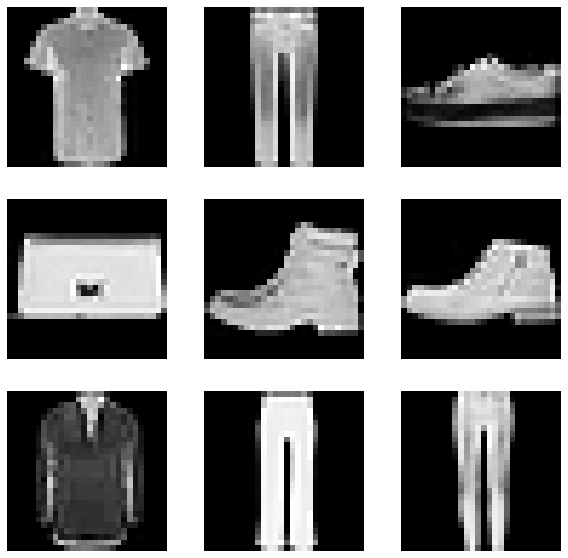

In [3]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    print(images[1,:,:,0])
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1.)#/255)

In [11]:
normalized_ds = np.array(normalized_ds)

In [86]:
maskss = layers.experimental.preprocessing.Rescaling(scale= 1.)

In [87]:
maskss = np.array(markss)

In [12]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(normalized_ds)

TypeError: in user code:

    <ipython-input-9-3bffb7f0fc3a>:1 None  *
        lambda x: normalization_layer(x)

    TypeError: 'numpy.ndarray' object is not callable


In [ ]:
maskss = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(maskss))
first_image = image_batch[0]
print(markss)

In [74]:
input_encoder = (520, 704, 1)
input_decoder = (2,)

In [7]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [8]:
sampling_model

<function __main__.sampling_model(distribution_params)>

In [9]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  

    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [10]:
enc = encoder(input_encoder)

In [11]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [12]:
# enc.save('vae-fashion-enc.h5')

In [13]:
input_1 = (2,)
input_2 = (2,)

In [14]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [15]:
final = sampling(input_1,input_2)

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [16]:
# final.save('sampling.h5')

In [17]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [18]:
dec = decoder(input_decoder)

In [19]:
# dec.save('vae-fashion-dec.h5')

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [21]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_losseeeee = kl_loss(mean, log_var)
    return  r_loss + kl_losseeeee

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, mask):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(mask, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [23]:
os.makedirs('tf_vae/fashion/training_weights', exist_ok=True)
os.makedirs('tf_vae/fashion/images', exist_ok=True)

In [24]:
def train(dataset,mask, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch, mask_batch in zip(dataset, mask):
            i+=1
            loss = train_step(image_batch, mask_batch)
#         for image_batch in dataset:
#             i += 1
#             loss = train_step(image_batch)
#             #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/fashion/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/fashion/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    m, v = enc(test_input, training=False)
    latent = final([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('tf_vae/fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

tf.Tensor(
[[ 9.0323973e-01 -7.4447834e-01]
 [-1.0667778e+00  3.5192049e-01]
 [ 1.4681624e-01 -9.6788692e-01]
 [-6.6500396e-01 -2.3814554e+00]
 [-3.5436836e-01  1.1832470e-01]
 [-1.0754004e+00  2.2629118e+00]
 [-1.3773690e+00 -2.3240100e-01]
 [ 5.1610178e-01  1.1155241e+00]
 [-1.3444115e+00  1.5877285e+00]
 [-5.5158935e-02  6.4228976e-01]
 [-2.1534797e-03  6.3566369e-01]
 [-2.1232021e-01  2.3837332e-01]
 [-1.6416454e-01  7.2185695e-01]
 [-2.5428236e-01  9.7651345e-01]
 [-3.8431302e-01  1.2306012e+00]
 [-6.3906312e-02 -1.0283968e+00]
 [-1.3330115e+00 -4.8495540e-01]
 [ 1.0981712e+00 -1.5325974e-01]
 [ 8.3710390e-01 -7.2906345e-01]
 [-7.7621353e-01  2.4522903e+00]
 [ 1.2848228e-01  9.8799270e-01]
 [ 3.6363688e-01 -9.5688164e-01]
 [-1.4765036e-01  8.3107942e-01]
 [ 9.9996936e-01  7.7086020e-01]
 [-1.6096824e+00 -8.4233157e-02]], shape=(25, 2), dtype=float32)
(25, 28, 28, 1)


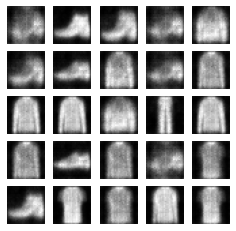

Time for epoch 1 is 74.62159991264343 sec


KeyboardInterrupt: 

In [26]:
train(normalized_ds, maskss, 100)

In [ ]:
enc.load_weights('tf_vae/fashion/training_weights/enc_99.h5')
dec.load_weights('tf_vae/fashion/training_weights/dec_99.h5')

## Latent Space Projection of Variational Autoencoder Trained on Fashion-MNIST

In [ ]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

m, v = enc.predict(example_images)
embeddings = final([m,v])



plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

In [24]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

## Reconstructing Fashion Images with Latent-Vector Sampled from Normal Distribution

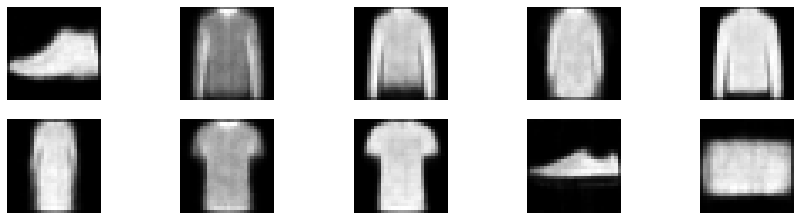

In [25]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

## Reconstructing Test Images

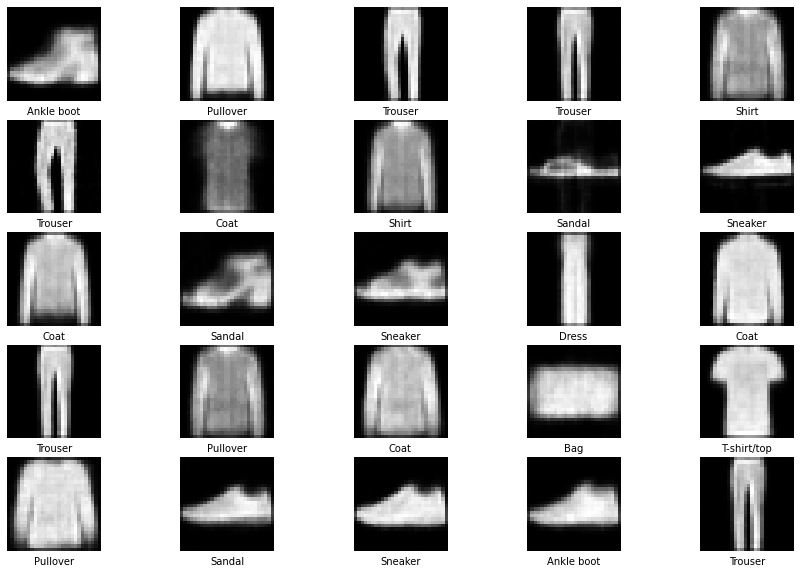

In [26]:
figsize = 15

m, v = enc.predict(x_test[:25])
latent = final([m,v])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

## Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

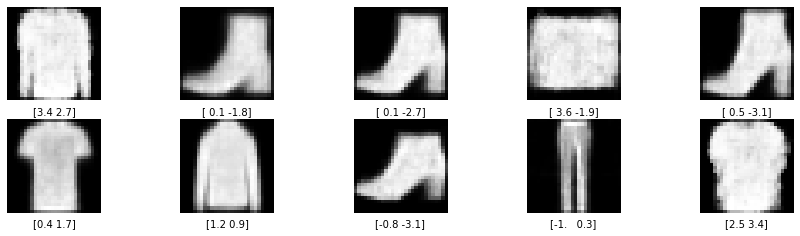

In [32]:
figsize = 15

min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])


x = np.random.uniform(min_x,max_x, size = (10,1))
y = np.random.uniform(min_y,max_y, size = (10,1))
z_grid = np.concatenate((x,y), axis=1)
reconst = dec.predict(z_grid)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')